In [1]:
import time
import hydra
from hydra.utils import to_absolute_path
import torch
import sys
import os
import torch.nn as nn

import argparse

from dgl.dataloading import GraphDataLoader
import dgl
from omegaconf import DictConfig

from torch.cuda.amp import GradScaler, autocast
from torch.nn.parallel import DistributedDataParallel

#project_path = os.path.abspath(os.path.join(os.path.dirname(__file__), '..', ''))
#sys.path.append(project_path)
project_path = os.path.abspath(os.path.join(os.getcwd(), '..', ''))
sys.path.append(project_path)

from python.create_dgl_dataset import TelemacDataset
from modulus.distributed.manager import DistributedManager
from modulus.launch.logging import (
    PythonLogger,
    RankZeroLoggingWrapper,
    initialize_wandb,
)
from modulus.launch.utils import load_checkpoint, save_checkpoint
from python.CustomMeshGraphNet import MeshGraphNet


In [2]:
from hydra.utils import to_absolute_path

In [3]:
import numpy as np

In [4]:
def collate_fn(batch):
    # batch is a list of sequences
    # Each sequence is a list of graphs (of length sequence_length)
    # We want to batch the graphs at each time step across sequences

    sequence_length = len(batch[0])  # Assuming all sequences have the same length

    batched_graphs = []
    for t in range(sequence_length):
        graphs_at_t = [sequence[t] for sequence in batch]
        batched_graph = dgl.batch(graphs_at_t)
        batched_graphs.append(batched_graph)

    return batched_graphs

class TestRollout:
    def __init__(self, cfg: DictConfig, logger: PythonLogger):
        self.sequence_length = cfg.sequence_length  # Use sequence_length from config
        
        # Set device
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        logger.info(f"Using {self.device} device")
        
        # Instantiate dataset
        self.dataset = TelemacDataset(
            name="telemac_test",
            data_dir=to_absolute_path(cfg.data_dir),
            dynamic_data_files=[to_absolute_path(path) for path in cfg.dynamic_dir],
            split="test",
            ckpt_path=cfg.ckpt_path,
            normalize=True,
            sequence_length=self.sequence_length,
        )
        print(len(self.dataset))
        # Instantiate dataloader
        self.dataloader = GraphDataLoader(
            self.dataset,
            batch_size=1,  
            shuffle=False,
            drop_last=False,
            collate_fn=collate_fn,  # Use custom collate_fn if defined
        )
        print(f"DataLoader Length: {len(self.dataloader)}")

        # Instantiate the model
        self.model = MeshGraphNet(
            cfg.num_input_features,
            cfg.num_edge_features,
            cfg.num_output_features,
            processor_size=cfg.mp_layers,
            hidden_dim_processor=64,
            hidden_dim_node_encoder=64,
            hidden_dim_edge_encoder=64,
            hidden_dim_node_decoder=64,
            do_concat_trick=cfg.do_concat_trick,
            num_processor_checkpoint_segments=cfg.num_processor_checkpoint_segments,
        )
        if cfg.jit:
            self.model = torch.jit.script(self.model).to(self.device)
        else:
            self.model = self.model.to(self.device)

        # Set model to evaluation mode
        self.model.eval()

        # Load checkpoint
        load_checkpoint(
            to_absolute_path(cfg.ckpt_path),
            models=self.model,
            device=self.device,
        )
        self.model = self.model.to(self.device)
        
        # Get the stats needed to denormalize and normalize
        node_stats = self.dataset.node_stats
        self.h_u_v_i_0_mean = np.array([
            node_stats['h'].item(),
            node_stats['u'].item(),
            node_stats['v'].item()
        ])
        self.h_u_v_i_0_std = np.array([
            node_stats['h_std'].item(),
            node_stats['u_std'].item(),
            node_stats['v_std'].item()
        ])

        self.delta_h_u_v_i_diff_mean = np.array([
            node_stats['delta_h'].item(),
            node_stats['delta_u'].item(),
            node_stats['delta_v'].item()
        ])
        self.delta_h_u_v_i_diff_std = np.array([
            node_stats['delta_h_std'].item(),
            node_stats['delta_u_std'].item(),
            node_stats['delta_v_std'].item()
        ])
        
        # Define feature indices
        self.dynamic_feature_start = 6  # Adjust based on your actual feature indices
        self.dynamic_feature_end = 9  # Adjust based on your actual feature indices
        
    def predict(self, graph):
        """
        Predicts the next time step given the input graph.
        Denormalizes input features and predictions.
        Returns the denormalized predicted values.
        """
        with torch.no_grad():
            pred = self.model(
                graph.ndata['x'].to(self.device),
                graph.edata['x'].to(self.device),
                graph.to(self.device)
            ).cpu().numpy()
        
        # Denormalize data
        h_u_v_i_0 = self._denormalize_data(
            graph.ndata['x'][:, self.dynamic_feature_start:self.dynamic_feature_end].numpy(),
            self.h_u_v_i_0_mean,
            self.h_u_v_i_0_std
        )

        # Compute predicted h, u, v at next time step
        h_u_v_i_1_pred = self._denormalize_data(
            pred,
            self.delta_h_u_v_i_diff_mean,
            self.delta_h_u_v_i_diff_std
        ) + h_u_v_i_0
                
        return h_u_v_i_1_pred, h_u_v_i_0
        
    def maj_mask(self, pred, next_step):
        """
        Updates predictions by applying boundary conditions from the next step.
        pred and next_step are normalized.
        """
        next_step_np = next_step.numpy()
        # Identify nodes with specific boundary conditions
        self.q_mask = (next_step_np[:, 0:4] == [0, 0, 1, 0]).all(axis=1)
        self.h_mask = (next_step_np[:, 0:4] == [0, 1, 0, 0]).all(axis=1)
        result = np.empty_like(next_step_np)
        
        # Copy static features from next_step
        result[:, 0:6] = next_step_np[:, 0:6]
        
        # Use predictions for dynamic features
        result[:, 6:9] = pred
        
        # Apply boundary conditions
        result[self.q_mask, 6:9] = next_step_np[self.q_mask, 6:9]
        result[self.h_mask, 6:7] = next_step_np[self.h_mask, 6:7]
        return result 
    
    def predict_unroll(self, unroll_steps=1):
        predict = []
        groundtruth = []
        origin = []
        for sequence in self.dataloader:
            # sequence is now a list of graphs
            sequence_length = len(sequence)
            if sequence_length < unroll_steps + 1:
                continue  # Skip sequences that are too short

            graph = sequence[0].clone()  # Start from the first graph in the sequence
            h_u_v_i_0 = None  # To store initial input at time t=0
            for i in range(unroll_steps):
                next_graph = sequence[i + 1]
                h_u_v_i_1_pred, h_u_v_i_0 = self.predict(graph)

                if i == 0:
                    origin.append(h_u_v_i_0)

                #noise_filter = h_u_v_i_1_pred[:, 0] < 5e-3
                #h_u_v_i_1_pred[noise_filter, :] = 0.0

                # Normalize the prediction to transfer to the next graph
                h_u_v_i_1_pred_norm = self._normalize_data(
                    h_u_v_i_1_pred,
                    self.h_u_v_i_0_mean,
                    self.h_u_v_i_0_std
                )

                # Apply boundary conditions
                next_step_result = self.maj_mask(
                    h_u_v_i_1_pred_norm,
                    next_graph.ndata['x']
                )

                # Update the graph's node features for the next prediction
                graph.ndata['x'] = torch.tensor(next_step_result, dtype=torch.float32)

            predict.append(h_u_v_i_1_pred)
            # Denormalize ground truth from next_graph
            groundtruth.append(self._denormalize_data(
                next_graph.ndata['x'][:, self.dynamic_feature_start:self.dynamic_feature_end].numpy(),
                self.h_u_v_i_0_mean,
                self.h_u_v_i_0_std
            ))

        return predict, groundtruth, origin

    def _denormalize_data(self, tensor, mean, std):
        assert tensor.shape[1] == mean.shape[0]
        return tensor * std + mean 
    
    def _normalize_data(self, tensor, mean, std):
        assert tensor.shape[1] == mean.shape[0]
        return (tensor - mean) / std
    
    def get_raw_data(self, idx):
        self.pred_i = [var[:, idx] for var in self.pred]
        self.exact_i = [var[:, idx] for var in self.exact]
        return self.graphs, self.faces, self.pred_i, self.exact_i



In [5]:
import hydra
from hydra import initialize, compose
from omegaconf import DictConfig, OmegaConf

import time 

# Initialize Hydra and set the configuration directory
with initialize(config_path="../bin/conf"):
    logger = PythonLogger("main")  # General python logger
    logger.file_logging()
    # Compose the configuration using the config name
    cfg = compose(config_name="Config1Group3Shortx16MultiTest")
    
    # Display the configuration (optional)
    print(OmegaConf.to_yaml(cfg))

    # Now call the training function with the composed config
    test = TestRollout(cfg,logger)
    
    t1 = time.time()
    predict,groundtruth,origin = test.predict_unroll(unroll_steps=10)
    t2 = time.time()
    
print("time per unroll {}".format((t2-t1)/len(test.dataloader)))
print(t1)
print(t2)
print(len(test.dataloader))

/tmp/ipykernel_634767/1374187299.py:8: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  with initialize(config_path="../bin/conf"):
[12:21:00 - main - INFO] Using cuda device


data_dir: /work/m24046/m24046mrcr/results_data_30min_35_70_maillagex16/Multimesh_16_32.bin
dynamic_dir:
- /work/m24046/m24046mrcr/results_data_30min_35_70_maillagex16/Group_3_peak_2200_Group_3_peak_2200_0_0-80_interpolated.pkl
batch_size: 1
epochs: 2001
mp_layers: 10
lr: 0.0005
lr_decay_rate: 0.999995
num_input_features: 9
num_output_features: 3
num_edge_features: 3
custom_loss: false
sequence_length: 11
use_apex: true
amp: true
jit: false
num_dataloader_workers: 1
do_concat_trick: true
num_processor_checkpoint_segments: 0
recompute_activation: false
ckpt_path: /work/m24046/m24046mrcr/new_tests_Group3/config1_short_x16_multimesh

Loading normalization statistics...
2
DataLoader Length: 2


[12:21:00 - checkpoint - INFO] Loaded model state dictionary /work/m24046/m24046mrcr/new_tests_Group3/config1_short_x16_multimesh/MeshGraphNet.0.2000.mdlus to device cuda
[12:21:00 - checkpoint - INFO] Loaded checkpoint file /work/m24046/m24046mrcr/new_tests_Group3/config1_short_x16_multimesh/checkpoint.0.2000.pt to device cuda


time per unroll 0.26732873916625977
1732360860.7277632
1732360861.2624207
2


In [6]:
from python.python_code.data_manip.extraction.telemac_file import TelemacFile
from python.create_dgl_dataset import add_mesh_info

#mesh_list = ['/work/m24046/m24046mrcr/results_data_30min/maillage_3.slf']
mesh_list = ['/work/m24046/m24046mrcr/results_data_30min_35_70_maillagex16/Mesh16_corrige.slf']
res_mesh = TelemacFile(mesh_list[0])
X,triangles = add_mesh_info(res_mesh)

In [7]:
def calculate_csi(predictions, observations, epsilon):
    """
    Calcule le Critical Success Index (CSI) entre deux tableaux de prédictions et d'observations.
    
    Parameters:
    predictions (numpy.ndarray): Un tableau numpy contenant les prédictions.
    observations (numpy.ndarray): Un tableau numpy contenant les observations réelles.
    epsilon (float): Le seuil pour déterminer les valeurs binaires (0 ou 1).
    
    Returns:
    float: Le Critical Success Index (CSI).
    """
    
    # Binariser les prédictions et les observations selon le seuil epsilon
    binary_predictions = (predictions >= epsilon).astype(int)
    binary_observations = (observations >= epsilon).astype(int)
    
    # Calculer les True Positives, False Positives et False Negatives
    TP = np.sum((binary_predictions == 1) & (binary_observations == 1))
    FP = np.sum((binary_predictions == 1) & (binary_observations == 0))
    FN = np.sum((binary_predictions == 0) & (binary_observations == 1))
    
    # Calculer le CSI
    csi = TP / (TP + FP + FN)
    
    return csi

L1_list= []
L1_list_persistence=[]
CSI_list = []

for pdt in range(len(groundtruth)) :
    ori = origin[pdt]
    gd = groundtruth[pdt]
    pred = predict[pdt]
    print(' pas de temps : {}'.format(pdt))
    L1_list.append(np.mean(np.abs(gd-pred)))
    L1_list_persistence.append(np.mean(np.abs(gd-ori)))
    print(L1_list[-1])
    print(L1_list_persistence[-1])
    CSI_list.append(calculate_csi(np.abs(pred[:,0]), np.abs(gd[:,0]), 1e-2))

 pas de temps : 0
0.08128954731962665
0.12732732521171053
 pas de temps : 1
0.06969298095107175
0.10006385080366478


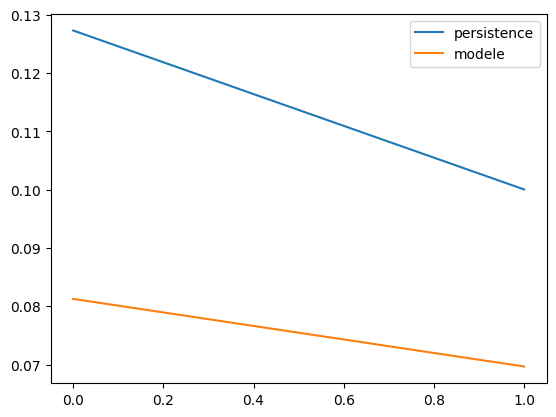

In [8]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(L1_list_persistence,label="persistence")
plt.plot(L1_list,label="modele")
plt.legend()
plt.show()

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

epsilon = 1e-2

def interpolate_and_classify(X, data, xi, yi, epsilon):
    """ Interpolate data and classify pixels based on epsilon """
    interp_data = griddata((X[:, 0], X[:, 1]), data[:, 0], (xi, yi), method='linear')
    interp_data = np.nan_to_num(interp_data,0.0)
    binary_data = np.zeros_like(interp_data)
    binary_data[interp_data >= epsilon] = 1  # Positive
    return interp_data, binary_data

def classify_prediction(pred_interp, gd_interp, epsilon):
    """ Classify pixels based on prediction and groundtruth """
    tp = (pred_interp >= epsilon) & (gd_interp >= epsilon)
    fn = (pred_interp < epsilon) & (gd_interp >= epsilon)
    fp = (pred_interp >= epsilon) & (gd_interp < epsilon)
    
    color_codes = np.zeros_like(pred_interp)
    color_codes[tp] = 1  # True Positive - Blue
    color_codes[fn] = 2  # False Negative - Red
    color_codes[fp] = 3  # False Positive - Green
    
    return color_codes

def plot_data(ax, data, title, cmap, bounds, norm):
    """ Plot interpolated data with a given colormap """
    ax.set_title(title)
    ax.pcolormesh(xi, yi, data, shading='auto', cmap=cmap, norm=norm)
    ax.set_aspect('equal')
    
# Create a grid
xi = np.linspace(np.min(X[:, 0]), np.max(X[:, 0]), 700)
yi = np.linspace(np.min(X[:, 1]), np.max(X[:, 1]), 700)
xi, yi = np.meshgrid(xi, yi)


In [24]:
print(len(test.dataloader))

2


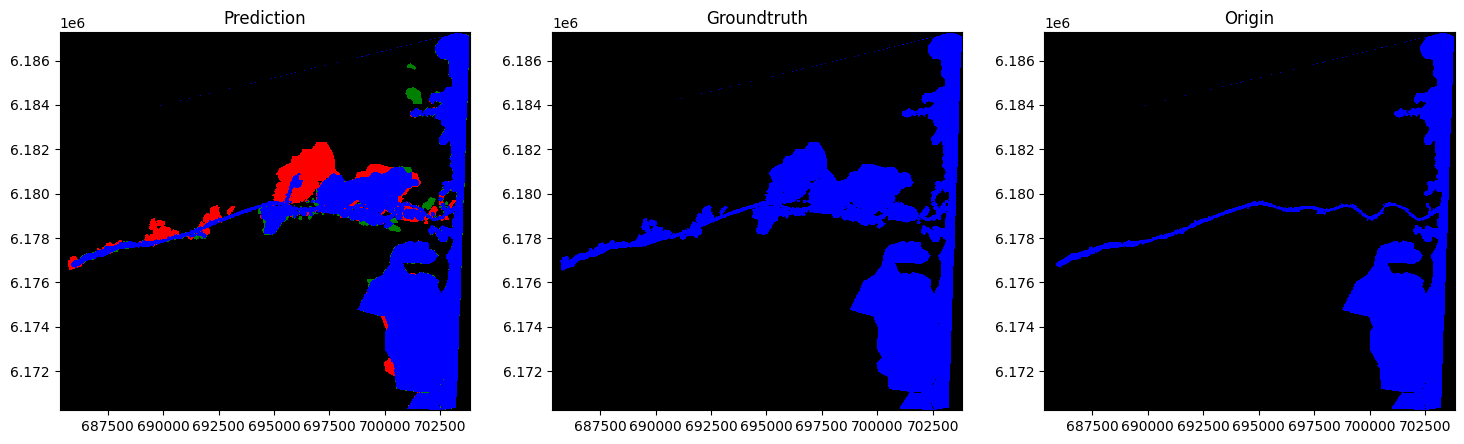

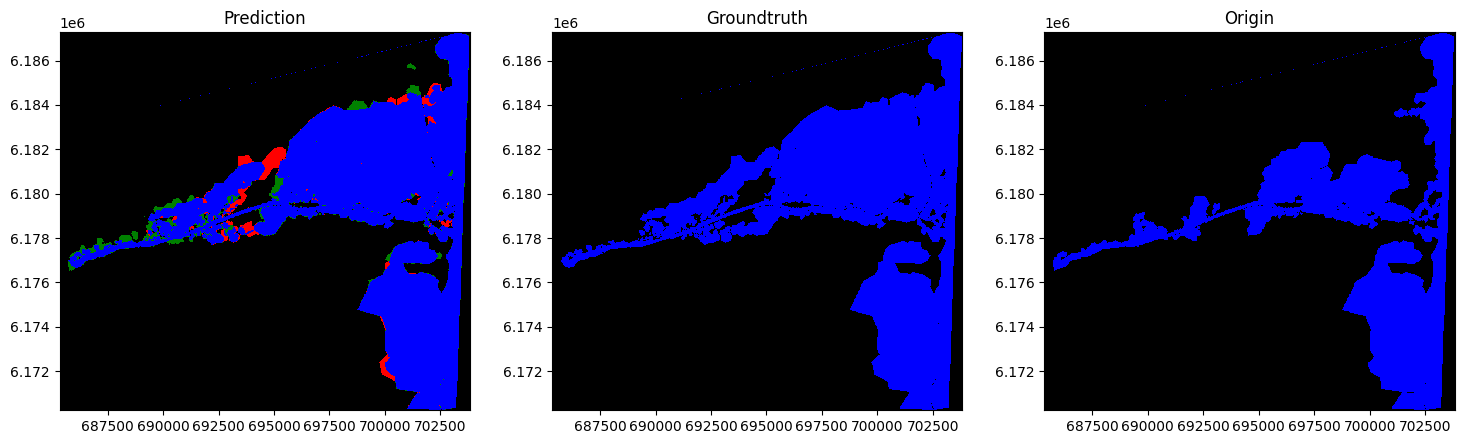

In [28]:

for pdt in range(len(test.dataloader)):
    gd = groundtruth[pdt]
    pred = predict[pdt]
    ori = origin[pdt]
    
    # Interpolate and classify the data
    pred_interp, binary_pred = interpolate_and_classify(X, pred, xi, yi, epsilon)
    gd_interp, binary_gd = interpolate_and_classify(X, gd, xi, yi, epsilon)
    ori_interp, binary_ori = interpolate_and_classify(X, ori, xi, yi, epsilon)
    
    # Classify prediction into TP, FN, FP
    color_codes = classify_prediction(pred_interp, gd_interp, epsilon)
    
    # Create colormaps
    prediction_cmap = plt.cm.colors.ListedColormap(['k', 'b', 'r', 'g'])  # Black, Blue, Red, Green
    groundtruth_cmap = plt.cm.colors.ListedColormap(['k', 'b'])  # Black, Blue
    norm_prediction = plt.cm.colors.BoundaryNorm([0, 0.5, 1.5, 2.5, 3.5], prediction_cmap.N)
    norm_groundtruth = plt.cm.colors.BoundaryNorm([0, 0.5, 1.5], groundtruth_cmap.N)
    
    # Plot
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    plot_data(axes[0], color_codes, 'Prediction', prediction_cmap, [0, 1, 2, 3], norm_prediction)
    plot_data(axes[1], binary_gd, 'Groundtruth', groundtruth_cmap, [0, 1], norm_groundtruth)
    plot_data(axes[2], binary_ori, 'Origin', groundtruth_cmap, [0, 1], norm_groundtruth)
    plt.show()

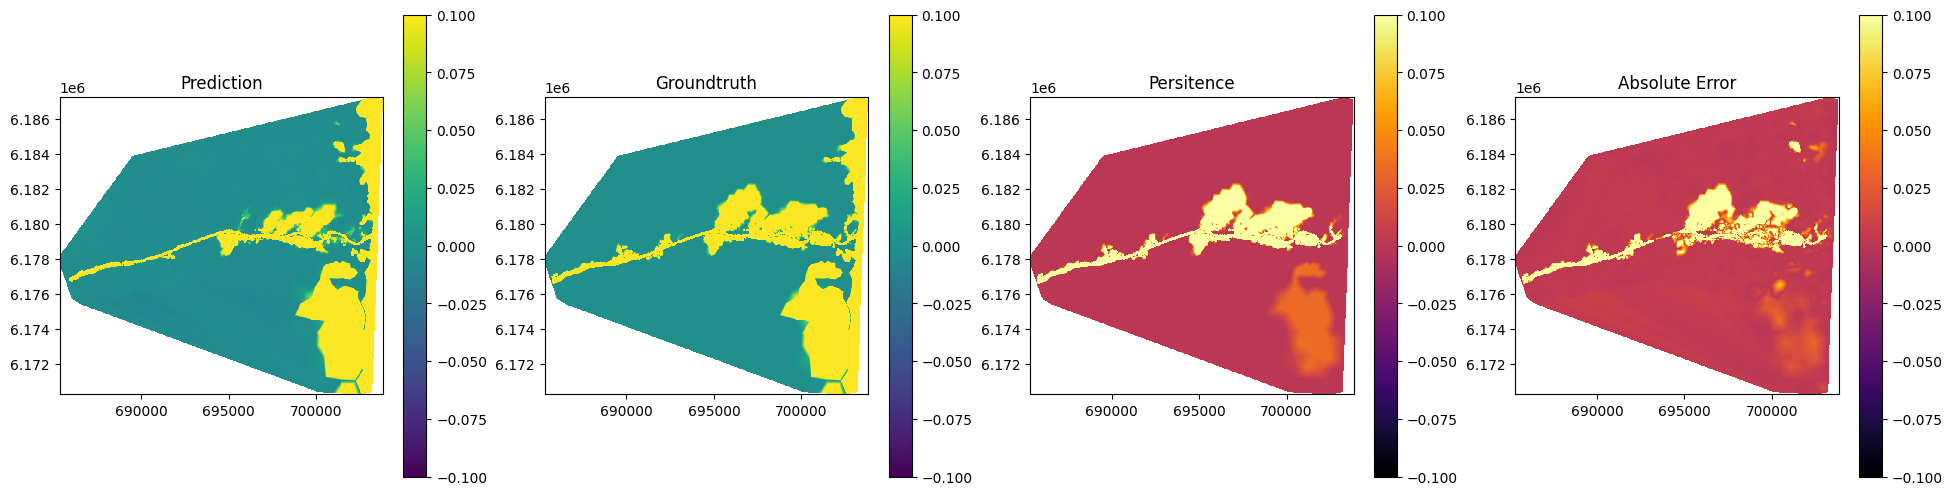

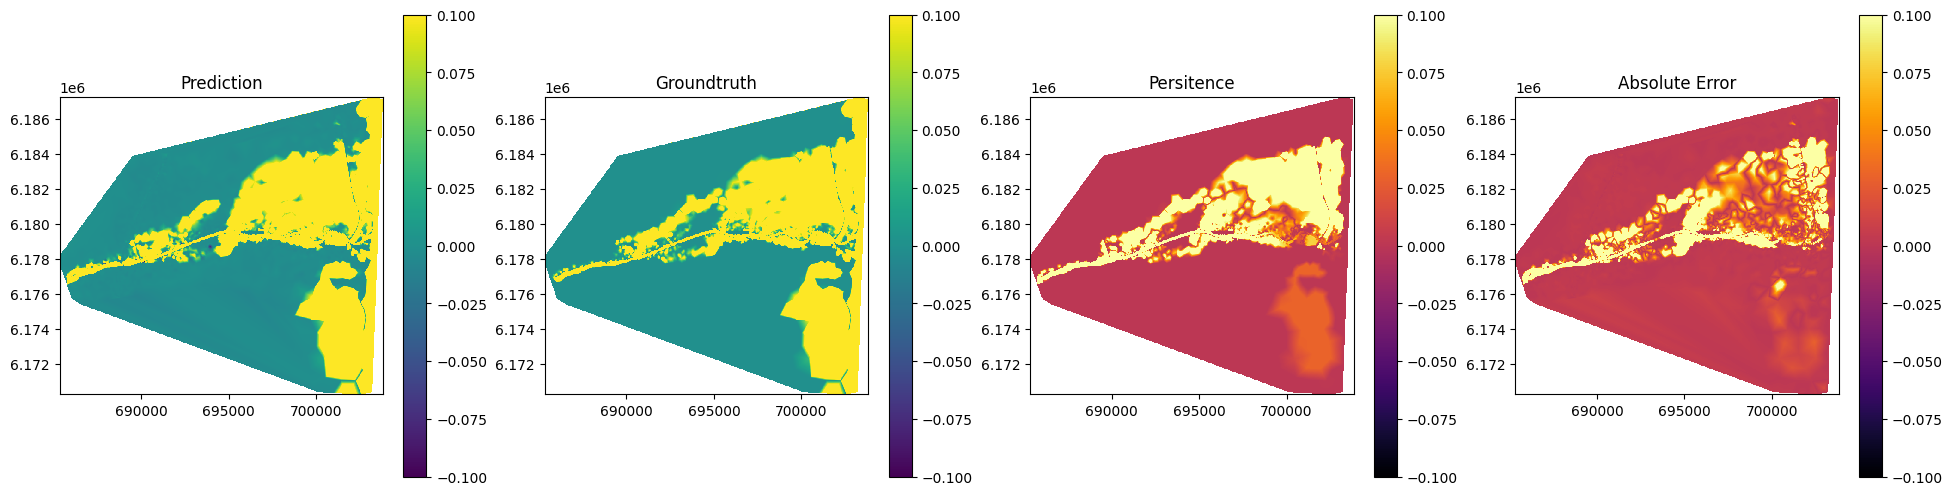

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

def interpolate_data(X, data, xi, yi):
    """ Interpolate data """
    return griddata((X[:, 0], X[:, 1]), data[:, 0], (xi, yi), method='linear')

def plot_data(ax, data, title, cmap, norm):
    """ Plot interpolated data with a given colormap """
    ax.set_title(title)
    c = ax.pcolormesh(xi, yi, data, shading='auto', cmap=cmap, norm=norm)
    fig.colorbar(c, ax=ax, orientation='vertical')
    ax.set_aspect('equal')

# Create a grid
xi = np.linspace(np.min(X[:, 0]), np.max(X[:, 0]), 700)
yi = np.linspace(np.min(X[:, 1]), np.max(X[:, 1]), 700)
xi, yi = np.meshgrid(xi, yi)

for pdt in range(len(groundtruth)):
    gd = groundtruth[pdt]
    pred = predict[pdt]
    ori = origin[pdt]
    
    # Interpolate data
    pred_interp = interpolate_data(X, pred, xi, yi)
    gd_interp = interpolate_data(X, gd, xi, yi)
    ori_interp = interpolate_data(X, ori, xi, yi)
    
    # Calculate absolute error
    abs_error = np.abs(pred_interp - gd_interp)
    
    abs_error_persistence = np.abs(ori_interp - gd_interp)
    
    
    # Create colormaps
    data_cmap = plt.cm.viridis  # Example colormap, adjust as needed
    norm_data = plt.Normalize(vmin=min(np.min(pred_interp), np.min(gd_interp), np.min(ori_interp)), 
                              vmax=max(np.max(pred_interp), np.max(gd_interp), np.max(ori_interp)))
    
    error_cmap = plt.cm.inferno  # Different colormap for error visualization
    norm_error = plt.Normalize(vmin=np.min(abs_error), vmax=np.max(abs_error))
    
    error_cmap_persitence = plt.cm.inferno  # Different colormap for error visualization
    norm_error_persitence = plt.Normalize(vmin=min(np.min(abs_error_persistence), np.min(abs_error)), 
                              vmax=max(np.max(abs_error_persistence), np.max(abs_error)))
        
    
    # Plot
    fig, axes = plt.subplots(1, 4, figsize=(24, 6))
    
    plot_data(axes[0], pred_interp, 'Prediction', data_cmap, norm_data)
    plot_data(axes[1], gd_interp, 'Groundtruth', data_cmap, norm_data)
    plot_data(axes[2], abs_error_persistence, 'Persitence', error_cmap_persitence, norm_error_persitence)
    plot_data(axes[3], abs_error, 'Absolute Error', error_cmap_persitence, norm_error_persitence)
    
    plt.show()


/tmp/ipykernel_634767/1985105683.py:49: UserWarning: Positional parameter c has no effect when the keyword facecolors is given
  plt.tripcolor(X[:, 0], X[:, 1], pred[:, 0] - ori[:, 0], triangles=triangles, facecolors=color_codes, cmap=prediction_cmap, norm=prediction_norm)


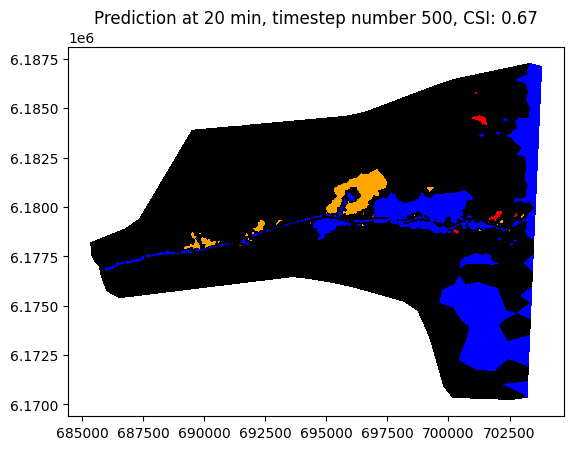

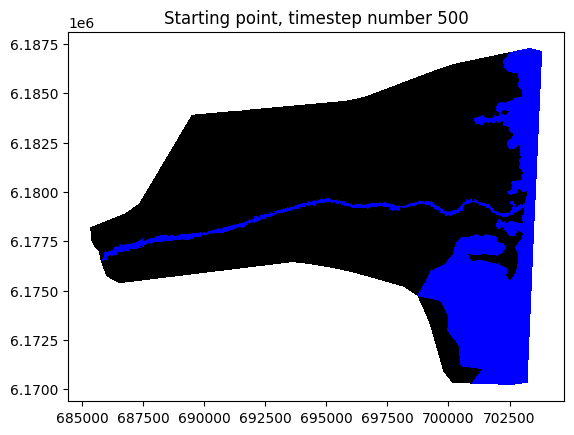

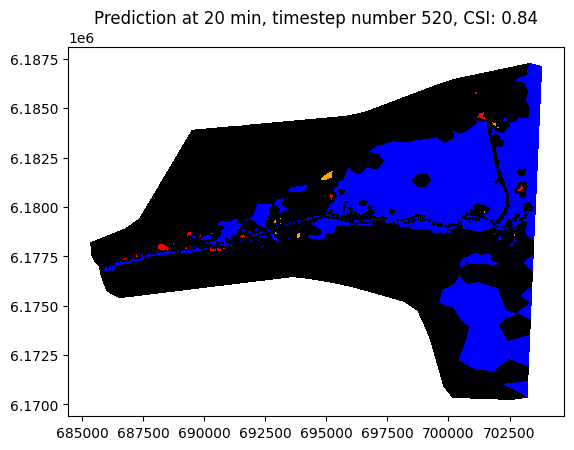

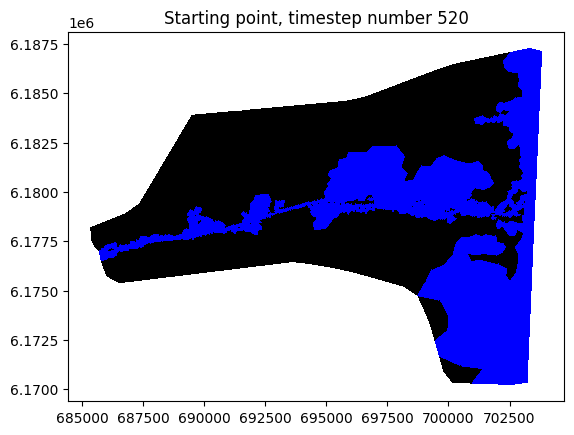

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

unroll_steps = 1
epsilon = 5e-3

# Define the full colormap for prediction (black, blue, red, orange)
prediction_cmap = mcolors.ListedColormap(['k', 'b', 'r', 'orange'])
prediction_bounds = [0, 1, 2, 3, 4]  # Boundaries for color mapping
prediction_norm = mcolors.BoundaryNorm(prediction_bounds, prediction_cmap.N)

# Define the simple colormap for the starting point (black, blue)
start_cmap = mcolors.ListedColormap(['k', 'b'])
start_bounds = [0, 0.5, 1]  # Boundaries for color mapping
start_norm = mcolors.BoundaryNorm(start_bounds, start_cmap.N)

for pdt in range(len(groundtruth)):
    gd = groundtruth[pdt]
    pred = predict[pdt]
    ori = origin[pdt]
    
    # Calculate CSI for this timestep (or use it in plotting as needed)
    csi = calculate_csi(pred[:, 0], gd[:, 0], epsilon=epsilon)
    
    # Define conditions
    tp = (pred[:, 0] >= epsilon) & (gd[:, 0] >= epsilon)
    fp = (pred[:, 0] >= epsilon) & (gd[:, 0] < epsilon)
    fn = (pred[:, 0] < epsilon) & (gd[:, 0] >= epsilon)
    
    # Initialize a numeric array for triangle colors for the prediction
    color_codes = np.zeros(triangles.shape[0])  # Default is 0 (black)
    
    for i, tri in enumerate(triangles):
        tp_avg = np.mean(tp[tri])
        fp_avg = np.mean(fp[tri])
        fn_avg = np.mean(fn[tri])
        
        if tp_avg == 1:  # All vertices are true positive
            color_codes[i] = 1  # Blue for true positive
        elif fp_avg == 1:  # All vertices are false positive
            color_codes[i] = 2  # Red for false positive
        elif fn_avg == 1:  # All vertices are false negative
            color_codes[i] = 3  # Orange for false negative
    
    # Plot prediction with full color mapping
    plt.figure()
    plt.title(f'Prediction at {20 * unroll_steps} min, timestep number {500 + pdt * 20}, CSI: {csi:.2f}')
    plt.tripcolor(X[:, 0], X[:, 1], pred[:, 0] - ori[:, 0], triangles=triangles, facecolors=color_codes, cmap=prediction_cmap, norm=prediction_norm)
    plt.show()
    
    # Plot starting point with triangles > epsilon in blue and others in black
    plt.figure()
    plt.title(f'Starting point, timestep number {500 + pdt * 20}')
    
    # Initialize a numeric array for triangle colors for the starting point
    start_color_codes = np.zeros(triangles.shape[0])  # Default is 0 (black)
    
    for i, tri in enumerate(triangles):
        ori_avg = np.mean(ori[tri, 0])  # Calculate the average value of the vertices in the triangle
        if ori_avg > epsilon:  # If the average value is greater than epsilon
            start_color_codes[i] = 1  # Blue
    
    # Plot starting point with simple color mapping
    plt.tripcolor(X[:, 0], X[:, 1], start_color_codes, triangles=triangles, cmap=start_cmap, norm=start_norm)
    plt.show()
    
    pdt += 1


In [ ]:
for pdt in range(len(groundtruth)) :
    gd = groundtruth[pdt]
    pred = predict[pdt]
    ori = origin[pdt]
    h_max = max(np.max(gd[:,0]),np.max(pred[:,0]))
    h_min = min(np.min(gd[:,0]),np.min(pred[:,0]))
    plt.figure()
    plt.title('prediction à 20 min, pas de temps numero {}'.format(500+pdt*20))
    plt.tripcolor(X[:,0],X[:,1],pred[:,0]-ori[:,0],triangles=triangles,vmax=h_max,vmin=h_min)
    #plt.xlim(685000,687500)
    #plt.ylim(6170000,6180000)
    plt.show()
                                                 
    plt.figure()
    plt.title('groundtruth à 20 min, pas de temps numero {}'.format(500+pdt*20))
    plt.tripcolor(X[:,0],X[:,1],gd[:,0]-ori[:,0],triangles=triangles,vmax=h_max,vmin=h_min)
    #plt.xlim(685000,687500)
    #plt.ylim(6170000,6180000)
    plt.show()
                                                 
    pdt+=1

In [ ]:
!ls /work/m24046/m24046mrcr/dataset_20_min/